In [1]:
import numpy as np
import pandas as pd
import requests
from hmmlearn import hmm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import time
from dateutil import parser
from matplotlib.collections import LineCollection
from itertools import product, zip_longest
import pickle
import os

In [2]:
def load_data():
    api_key = "beb360aad13e472f96c86f55e97b5bd9"
    # url = "http://api.eia.gov/series/?api_key={}&series_id=EBA.NY-ALL.D.HL".format(api_key)
    url = "http://api.eia.gov/series/?api_key={}&series_id=EBA.NY-ALL.D.H".format(api_key)
    response = requests.get(url)
    data = pd.DataFrame(response.json()['series'][0]['data'],columns = ['DateTime', 'Mwh'])
    data['DateTime'] = data['DateTime'].apply(lambda x: datetime.strptime(x, '%Y%m%dT%HZ'))
    data['Date'] = data['DateTime'].apply(lambda x: x.date())
    data['Time'] = data['DateTime'].apply(lambda x: x.time())
    data['Mwh'] = data['Mwh'].replace(0,np.nan).interpolate()
    splits = []
    splits.append(data[data['Date'] < datetime(year =2018, month=1, day = 1).date()])
    splits.append(data[(data['Date'] >= datetime(year =2018, month=1, day = 1).date()) & 
                       (data['Date'] < datetime(year =2019, month=1, day = 1).date())])
    splits.append(data[data['Date'] >= datetime(year =2019, month=1, day = 1).date()])
    for idx in range(len(splits)):
        splits[idx] = splits[idx].iloc[::-1].reset_index(drop=True)
        splits[idx] = splits[idx].set_index(['DateTime'])[['Date','Time','Mwh']]
    return splits[0], splits[1], splits[2]
train, val, test = load_data()

In [3]:
#create train df sorted by year, month, day and summed by day
times_train = pd.DatetimeIndex(train.index)
train_ymdh = train.groupby([times_train.month,times_train.day,times_train.hour]).mean()

#create val df sorted by year, month, day and summed by day
times_val = pd.DatetimeIndex(val.index)
val_ymdh = val.groupby([times_val.month,times_val.day,times_val.hour]).mean()

#create test df sorted by year, month, day and summed by day
times_test = pd.DatetimeIndex(test.index)
test_ymdh = test.groupby([times_test.month,times_test.day,times_test.hour]).mean()

In [6]:
train_ymdh.loc[1]

Mwh
DateTime DateTime         
1        0         19826.5
         1         19169.0
         2         18502.0
         3         17745.0
         4         16953.0
...                    ...
31       19        18717.5
         20        18622.0
         21        18619.5
         22        19035.0
         23        20160.0

[744 rows x 1 columns]

In [7]:
12*30*24

8640

In [9]:
# The covariance of each component
covars = .5 * np.tile(np.identity(2), (4, 1, 1))
covars.shape

(4, 2, 2)

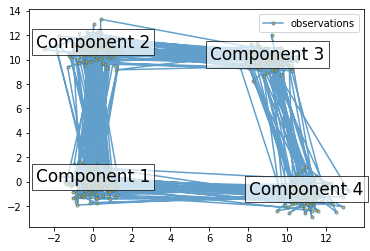

In [10]:
"""
Sampling from HMM
-----------------

This script shows how to sample points from a Hiden Markov Model (HMM):
we use a 4-components with specified mean and covariance.

The plot show the sequence of observations generated with the transitions
between them. We can see that, as specified by our transition matrix,
there are no transition between component 1 and 3.
"""
##############################################################
# Prepare parameters for a 4-components HMM
# Initial population probability
startprob = np.array([0.6, 0.3, 0.1, 0.0])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0.7, 0.2, 0.0, 0.1],
                     [0.3, 0.5, 0.2, 0.0],
                     [0.0, 0.3, 0.5, 0.2],
                     [0.2, 0.0, 0.2, 0.6]])
# The means of each component
means = np.array([[0.0,  0.0],
                  [0.0, 11.0],
                  [9.0, 10.0],
                  [11.0, -1.0]])
# The covariance of each component
covars = .5 * np.tile(np.identity(2), (4, 1, 1))

# Build an HMM instance and set parameters
model = hmm.GaussianHMM(n_components=4, covariance_type="full")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars
###############################################################

# Generate samples
X, Z = model.sample(500)

# Plot the sampled data
plt.plot(X[:, 0], X[:, 1], ".-", label="observations", ms=6,
         mfc="orange", alpha=0.7)

# Indicate the component numbers
for i, m in enumerate(means):
    plt.text(m[0], m[1], 'Component %i' % (i + 1),
             size=17, horizontalalignment='center',
             bbox=dict(alpha=.7, facecolor='w'))
plt.legend(loc='best')
plt.show()
